# Understand CMS gaussian beam spot fitter

The goal of this example is to demonstrate that the "width" parameters of CMS beam spot fit are different from the proper widths of the luminous regions, that is the gaussian widths as measured in the reference frame of the luminous region itself (without correlations, diagonal covariance matrix).  

In the following we'll stick to the 2D case, which is easier to illustrate.  

We'll first generate a set of normally distributed points without any x, y correlation and fit this distributions with a generic 2D gaussian model, where the covariance matrix is defined as
$$\Sigma_{\textrm{beam}}^{\textrm{CMS}} =  \begin{pmatrix}
  (\sigma_{x}^{\textrm{eff}})^2 & \rho * \sigma_{x}^{\textrm{eff}} *\sigma_{y}^{\textrm{eff}} \\
   \rho * \sigma_{x}^{\textrm{eff}} *\sigma_{y}^{\textrm{eff}} & (\sigma_{y}^{\textrm{eff}})^2 \\
 \end{pmatrix}$$
 
 in this case, because there no rotation and hence no correlation between x and y the fitted effective widths will match the _true_ widths.  
 
In the second part of the example we'll rotate the generated distribution, but withough changing the true widths.
This time, the fitted effective widths will significantly differ from the true widths.

The latter case actually shows what we do in CMS when fitting the vertex distribution to extract the luminous region parameters.  
The width parameters are in fact the _effective_ widths as projected onto CMS' reference frame and not the _true_ widths of the luminous region.

## no rotations

In [2]:
import iminuit
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal

Define function to compute the 2D covariance matrix.  
It is done by rotating the diagonal matrix of the X and Y widths.  
In this case sigma_x and sigma_y are the proper widths of the distribution.

In [3]:
def compute_covariance_matrix(theta, sigma_x, sigma_y):
    '''
    https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Density_function
    '''
    rot = np.matrix([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)],
    ]).astype(np.float64)
    
    widths = np.matrix([
        [ np.power(sigma_x, 2), 0.                  ],
        [ 0.                  , np.power(sigma_y, 2)],
    ]).astype(np.float64)
    
    cov = rot * widths * rot.T
    
    return cov

define generator function.  
Generates (x,y) points according to a 2D gaussian PDF.  
The widths are the _true_ widths of the distribution.

In [4]:
def generate(pos, theta, sigma_x, sigma_y, ntoys=10000, seed=1986):
    '''
    '''
    # build the covariance matrix from angles and widths
    cov = compute_covariance_matrix(
        theta   = theta  , #[rad]
        sigma_x = sigma_x, #[cm]
        sigma_y = sigma_y, #[cm]
    )
    
    # fix random seed
    rng = np.random.RandomState(seed)
    
    # generate multivariate normal
    mvg = rng.multivariate_normal(pos, cov, ntoys)
    
    # return points
    return mvg


generate events with a non rotated 2D gaussian, centred in 0

In [5]:
points = generate([0., 0.], 0., 10., 1.)
print points

[[ -7.76979035   0.12661351]
 [  8.48737694   0.23162548]
 [ 18.30533362   0.40549799]
 ..., 
 [ -5.23972591  -0.42021809]
 [ -9.12913277   0.93488155]
 [ 22.51090179   0.93359008]]


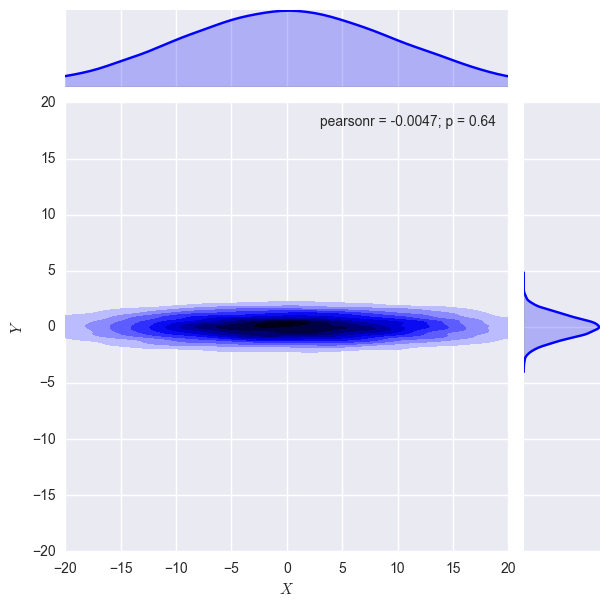

In [6]:
g = sns.jointplot(x=points[:,0], y=points[:,1], data=points, kind="kde", color="b")
g.plot_joint(plt.scatter, c="w", s=0, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$");
plt.xlim([-20,20])
plt.ylim([-20,20])
plt.show()

define fitter class

In [7]:
class fitter():
    '''
    generic 2D gaussian fitter.
    '''
    def __init__(self, points, verbose=False):
        self.points = points
        self.positions = np.mean(points, axis=0)
        self.widths = np.std(points, axis=0)
        self.verbose = verbose

    def nll(self, x, y, rho, sigma_x_eff, sigma_y_eff):
        
        if self.verbose:
            print '\n'
            print 'x:'          , x
            print 'y:'          , y
            print 'rho:'        , rho
            print 'sigma_x_eff:', sigma_x_eff
            print 'sigma_y_eff:', sigma_y_eff

        cov = np.matrix([
            [np.power(sigma_x_eff, 2)       , rho * sigma_x_eff * sigma_y_eff],
            [rho * sigma_x_eff * sigma_y_eff, np.power(sigma_y_eff, 2)       ],
        ])
        
        if np.linalg.det(cov) > 0.:
            nll = -multivariate_normal.logpdf(self.points,
                                              mean=np.array([x, y]),
                                              cov=cov).sum()
        else:
            print 'WARNING! Singular covariance matrix, cannot invert!'
            return float('nan')

        if self.verbose:
            print 'nLL:', nll
        
        return nll
    
    def fit(self):
        minimizer = iminuit.Minuit(
            self.nll,
            pedantic=False,
            x=self.positions[0],
            y=self.positions[1],
            rho=0.,
            sigma_x_eff=self.widths[0],
            sigma_y_eff=self.widths[1],
        )
        try:
            # run the minimization            
            minimizer.migrad()            
        except:
            print 'ERROR! NLL Minimization failed'
        
        return minimizer


In [8]:
myfitter = fitter(points)

In [9]:
print 'mean x, y:', myfitter.positions
print 'RMS x, y:', myfitter.widths

mean x, y: [ 0.05492877 -0.00855997]
RMS x, y: [ 10.04436708   0.99729019]


In [10]:
results = myfitter.fit()

FCN = 51421.6459176 
 TOTAL NCALL = 71 
 NCALLS = 71 
 
 
 EDM = 2.13668253961e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x,0.0549288,0.142049,0,0,,,
2,y,-0.00855997,0.0141038,0,0,,,
3,rho,-0.00468537,0.0141417,0,0,,,
4,sigma_x_eff,10.0444,0.100444,0,0,,,
5,sigma_y_eff,0.997291,0.00997289,0,0,,,


when the 2D gaussian is not titled, the fitted effective widths are equal to the proper widths of the generated distribution.

## Now, what if we rotate the 2D gaussian by .5 radians?

mean x, y: [-0.04410067 -0.03384633]
RMS x, y: [ 8.8254817   4.89844573]


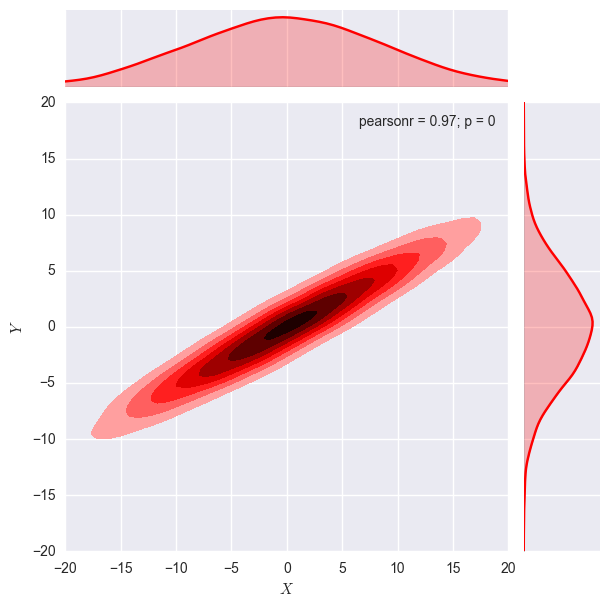

In [11]:
points_rot = generate([0., 0.], .5, 10., 1.)
myfitter_rot = fitter(points_rot)
print 'mean x, y:', myfitter_rot.positions
print 'RMS x, y:', myfitter_rot.widths
#plt.scatter(points_rot[:,0], points_rot[:,1], color='r')
#sns.jointplot(x=points_rot[:,0], y=points_rot[:,1], data=points, kind="kde")

g = sns.jointplot(x=points_rot[:,0], y=points_rot[:,1], data=points_rot, kind="kde", color="r")
g.plot_joint(plt.scatter, c="w", s=0, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$");


plt.xlim([-20,20])
plt.ylim([-20,20])
plt.show()

In [12]:
results_rot = myfitter_rot.fit() # never mind the warnings, as long as the fit converges properly they're of no interest

WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Sin

/Users/manzoni/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
              x = -0.044101
              y = -0.033846
            rho = +4.863543
    sigma_x_eff = +8.825556
    sigma_y_eff = +4.898478

/Users/manzoni/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
              x = nan
              y = nan
            rho = nan
    sigma_x_eff = nan
    sigma_y_eff = nan

/Users/manzoni/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
              x = -0.044101
              y = -0.033846
            rho = +1.026984
    sigma_x_eff = +8.819015
    sigma_y_eff = +4.894890



FCN = 51421.6459513 
 TOTAL NCALL = 105 
 NCALLS = 105 
 
 
 EDM = 3.47802660632e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x,-0.0448088,0.124613,0,0,,,
2,y,-0.0342394,0.0691644,0,0,,,
3,rho,0.972786,0.000758234,0,0,,,
4,sigma_x_eff,8.82546,0.0875335,0,0,,,
5,sigma_y_eff,4.89843,0.0485841,0,0,,,


as expected, the effecive widths do differ from the true widths!